In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import matplotlib
import itertools

In [87]:
def make_mesh_and_sol(n_nodes=10):
    coords_nodes = 2 * np.random.rand(n_nodes, 2) - 1
    corners = np.array([[-1, -1], [-1, 1], [1, -1], [1, 1]])
    coords_nodes = np.concatenate([coords_nodes, corners])

    def func(x, y):
        return -np.exp(x) + np.exp(y)

    values_nodes = func(coords_nodes[:, 0], coords_nodes[:, 1])
    
    mesh = Delaunay(coords_nodes)

    return mesh, values_nodes


make_mesh_and_sol(10)[0].points.shape, make_mesh_and_sol(10)[1].shape

((14, 2), (14,))

In [88]:
def make_grid(n_grid = 10):
    grid_points = np.linspace(-1, 1, n_grid)
    x_grid, y_grid = np.meshgrid(grid_points, grid_points)
    
    grid = np.hstack([x_grid.flatten()[:, None], y_grid.flatten()[:, None]])

    return x_grid, y_grid, grid


make_grid()[0].shape, make_grid()[1].shape, make_grid()[2].shape

((10, 10), (10, 10), (100, 2))

In [153]:
def shape_func(coord, el_coords):
    x1 = el_coords[0][0]; y1 = el_coords[0][1]
    x2 = el_coords[1][0]; y2 = el_coords[1][1]
    x3 = el_coords[2][0]; y3 = el_coords[2][1]
    
    a0 = x1; b0 = y1
    a1 = x2 - x1; b1 = y2 - y1
    a2 = x3 - x1; b2 = y3 - y1
    
    xhat = coord[0]; yhat = coord[1]
    
    etahat = (a1*yhat - b1*xhat + b1*a0 - a1*b0) / (a1*b2 - a2*b1)
    xihat = (xhat - a0 - a2*etahat) / a1
        
    n1 = 1 - xihat - etahat
    n2 = xihat
    n3 = etahat
    
    n = np.array([n1, n2, n3])
    
    return n


el_coords = np.array([[0, 0], [1, 0], [0, 1]])
x = [0, 0]

shape_func(x, el_coords)

array([1., 0., 0.])

In [268]:
mesh, value_nodes = make_mesh_and_sol(20)

In [274]:
x_grid, y_grid, grid = make_grid(5)

In [275]:
from pprint import pprint

def find_grids_in_each_element(grid, mesh):
    # grid_to_triangle = mesh.find_simplex(grid)
    
    # triangle_list = np.unique(grid_to_triangle)
    
    # elements_grid_point = [
    #     np.where(grid_to_triangle==e)[0]
    #     for e in triangle_list
    # ]
    point_to_element = mesh.find_simplex(grid)
    elements = np.unique(point_to_element)

    element_to_point = [None for e in range(len(mesh.simplices))]

    for eid in range(len(element_to_point)):
        element_to_point[eid] = np.where(point_to_element==eid)[0]
    
    return element_to_point
 

sum(len(f) for f in find_grids_in_each_element(grid, mesh))

25

In [276]:
def plot_mesh_value_grid(mesh, values_nodes, ax, x_grid=None, y_grid=None):
    triangulation = matplotlib.tri.Triangulation(mesh.points[:, 0], mesh.points[:, 1], mesh.simplices)

    ax_cont = ax.tricontourf(triangulation, values_nodes);
    ax.triplot(triangulation, color='b');
    # if x_grid is not None and y_grid is not None:
    #     ax.scatter(x_grid, y_grid, color='r', s=0.1)
        
    return ax_cont


def plot_grid_value(x_grid, y_grid, grid_values, ax):
    ax_cont = ax.contourf(x_grid, y_grid, grid_values.reshape(*y_grid.shape))
    ax.scatter(x_grid, y_grid, color='r', s=10)
    return ax_cont

In [277]:
elements_grids_nums = find_grids_in_each_element(grid, mesh)

grid_values = [None for g in range(len(grid))]

for e, grid_nums in enumerate(elements_grids_nums):
    el_nodes = mesh.simplices[e]
    el_coords = mesh.points[el_nodes]
    el_values = value_nodes[el_nodes]
    
    for grid_num in grid_nums:
        grid_coord = grid[grid_num]
        n = shape_func(grid_coord, el_coords)
        grid_value = n.dot(el_values)

        grid_values[grid_num] = grid_value
              
grid_values = np.array(grid_values)

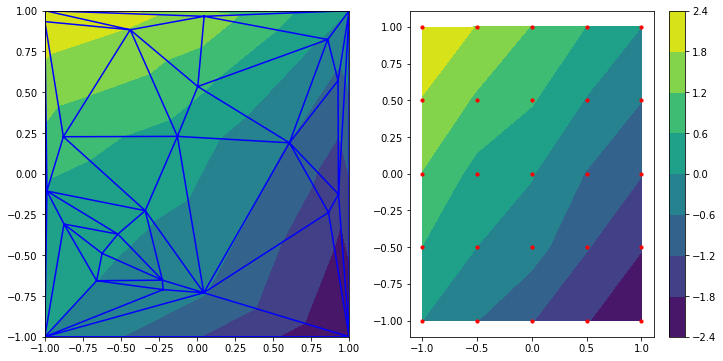

In [278]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 6))
ax_cont1 = plot_mesh_value_grid(mesh, value_nodes, ax0, x_grid, y_grid)
ax_cont2 = plot_grid_value(x_grid, y_grid, grid_values, ax1)
fig.colorbar(ax_cont1, ax=ax1)
fig.colorbar(ax_cont2, ax=ax2)

In [211]:
np.hstack([mesh.points, value_nodes[:, np.newaxis]])

array([[ 0.20300986, -0.65955298, -0.70800211],
       [-0.24520553,  0.29386233,  0.5590555 ],
       [-0.8681567 ,  0.14367404,  0.73478321],
       [ 0.28620886,  0.13631467, -0.18532803],
       [-1.        , -1.        ,  0.        ],
       [-1.        ,  1.        ,  2.35040239],
       [ 1.        , -1.        , -2.35040239],
       [ 1.        ,  1.        ,  0.        ]])

In [216]:
np.hstack([grid, grid_values[:, np.newaxis]])

array([[-1.        , -1.        ,  1.05783885],
       [ 1.        , -1.        , -2.35040239],
       [-1.        ,  1.        ,  4.14617527],
       [ 1.        ,  1.        , -6.89184003]])

In [237]:
for e, grid_nums in enumerate(elements_grids_nums):
    el_nodes = mesh.simplices[e]
    el_coords = mesh.points[el_nodes]
    el_values = value_nodes[el_nodes]
    if e == 2:
        print(e, el_values)
        print(el_coords)
    for grid_num in grid_nums:
        grid_coord = grid[grid_num]
        n = shape_func(grid_coord, el_coords)
        grid_value = n.dot(el_values)
        if e == 2:
            print()
            print(grid_coord)
            print(n)
            print(grid_nums, grid_value)


2 [-0.18532803 -0.70800211 -2.35040239]
[[ 0.28620886  0.13631467]
 [ 0.20300986 -0.65955298]
 [ 1.         -1.        ]]

[-1. -1.]
[-1.02757298  3.42974441 -1.40217142]
[0] 1.0578388505253171


In [227]:
mesh.simplices

array([[7, 3, 6],
       [6, 0, 4],
       [3, 0, 6],
       [2, 5, 4],
       [0, 2, 4],
       [1, 0, 3],
       [1, 2, 0],
       [2, 1, 5],
       [1, 7, 5],
       [7, 1, 3]], dtype=int32)

In [229]:
elements_grids_nums

[array([1]), array([2]), array([0]), array([3])]

In [262]:
point_to_element = mesh.find_simplex([[-1, -1], [1, -1]])
elements = np.unique(point_to_element)

element_to_point = [None for e in range(len(mesh.simplices))]

for eid in range(len(element_to_point)):
    element_to_point[eid] = np.where(point_to_element==eid)[0]
    
element_to_point

[array([], dtype=int64),
 array([1]),
 array([], dtype=int64),
 array([], dtype=int64),
 array([0]),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64),
 array([], dtype=int64)]